# Working with Radio Sounding Data
This is a short tutorial how to work with sounding data using [MetPy](https://unidata.github.io/MetPy/latest/index.html#).

In [2]:
# first some packages and functions are imported
import pandas as pd
import numpy as np
# functions for downloading the data
from soundings import (create_url, from_day_time, check_todays_sounding, 
                       write_csvfile, download_sounding, create_dataframe)

## Downloading the current sounding data
The data is provided on this [website](http://weather.uwyo.edu/upperair/sounding.html). For this step MetPy is not necessary.

In [3]:
# This functions downloads the data of the last sounding and creates a pandas dataframe
# Help: download_sounding?
# Default: Innsbruck
# Examples: station_id='16080' (Milan)
df = download_sounding()
df

On this homepage you can find the data:
http://weather.uwyo.edu/cgi-bin/sounding?region=europe&TYPE=TEXT%3ALIST&YEAR=2018&MONTH=11&FROM=1800&TO=1823&STNM=11120


,pres,hght,temp,dwpt,relh,mixr,drct,speed,thta,thte,thtv
0,956.0,593,-3.1,-3.9,94,3.01,150,2,273.5,281.9,274.0
1,925.0,841,-1.7,-3.5,88,3.21,100,4,277.6,286.6,278.1
2,882.0,1219,-3.3,-3.5,99,3.36,100,4,279.7,289.3,280.3
3,853.0,1485,-2.1,-5.4,78,3.01,100,4,283.6,292.4,284.2
4,850.0,1513,-2.3,-5.7,77,2.95,100,4,283.7,292.3,284.2
5,812.0,1876,-2.3,-11.3,50,1.99,125,7,287.5,293.5,287.8
6,790.0,2093,-4.1,-12.1,54,1.92,140,9,287.8,293.6,288.1
7,785.0,2143,-2.9,-15.9,36,1.42,143,10,289.6,294.0,289.9
8,782.0,2173,-3.1,-15.8,37,1.43,145,10,289.6,294.1,289.9
9,743.0,2575,-6.5,-14.5,53,1.68,118,12,290.3,295.5,290.6


The names of the columns stand for:

- pres: - Pressure in hPa
- hght: - Geopotential Height in m
- temp: - Temperature in °C
- dwpt: - Dewpoint Temperature in °C
- relh: - Relative Humidity in %
- mixr: - Mixing Ratio in gram/kilogram
- drct: - Wind Direction in degrees true
- speed: - Wind Speed in knot
- thta: - Potential Temperature in K
- thte: - Equivalent Potential Temperature in K
- thtv: - Virtual Potential Temperature in K


If MetPy is not yet installed on your PC: you can download it like it is described here: https://unidata.github.io/MetPy/latest/installguide.html

In [10]:
# for using MetPy we need a few more packages and functions
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import Hodograph, SkewT
from metpy.units import units

MetPy gives us the opportunity to assign units to physical quantities. This is mandatory for using some of its functions. The corresponding package is called 'units'. There has to be paid attention when using it for temperature, see [here](https://pint.readthedocs.io/en/latest/nonmult.html).

In [5]:
# assigning the appropriate units to the physical quantities
p = df['pres'].values * units.hPa
h = df['hght'].values * units.meters
t = df['temp'].values * units.celsius
dt = df['dwpt'].values * units.celsius
rh = df['relh'].values * units.percent
mr = df['mixr'].values * units.gram / units.kilogram
dr = df['drct'].values * units.degree
ws = df['speed'].values * units.knot
thta = df['thta'].values * units.kelvin
thte = df['thte'].values * units.kelvin
thtv = df['thtv'].values * units.kelvin

In [6]:
# calculation of the windspeed in x- and y-direction with the implemented functions
df['u_wind'], df['v_wind'] = mpcalc.wind_components(df['speed'],
                                                    np.deg2rad(df['drct']))
wind_speed = df['speed'].values * units.knots
wind_dir = df['drct'].values * units.degrees
u, v = mpcalc.wind_components(wind_speed, wind_dir)

## Calculations with MetPy

[Here](https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.html) you can find the supported calculations one can do with MetPy. In the following we have a look at a few of them.
(The examples are mostly taken from the [MetPy-Tutorial](https://unidata.github.io/MetPy/latest/tutorials/upperair_soundings.html#sphx-glr-tutorials-upperair-soundings-py).)

### LCL (lifted condensation level) and parcel profile
[Documentation of lcl](https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.lcl.html#metpy.calc.lcl), 
[Documentation of parcel profile](https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.parcel_profile.html#metpy.calc.parcel_profile)

In [7]:
# Calculate the LCL
# use first entry in pressure, temperature and dewpoint temperature
lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], t[0], dt[0])

print(lcl_pressure, lcl_temperature)

# Calculate the parcel profile.
parcel_prof = mpcalc.parcel_profile(p, t[0], dt[0]).to('degC')

944.0618845158035 hectopascal -4.067547538890513 degC


### Advanced Skew-T Plotting with an added Hodograph

The hodograph should show values from the surface up to 400 hPa. Therefore we will have to pick only the corresponding values for all quantities. In the next step we find out the index of the pressure entry at 400 hPa or the next higher, if 400 hPa is not exactly measured. We will use it later on.

In [8]:
# search for the index of the entry in pressure which equals 400 hPa:
for idx, element in enumerate(p):
    if element <= (400 * units.hPa):
        index400 = idx
        break
# we do the same for 100 hPa:
for idx, element in enumerate(p):
    if element <= (200 * units.hPa):
        index100 = idx
        break

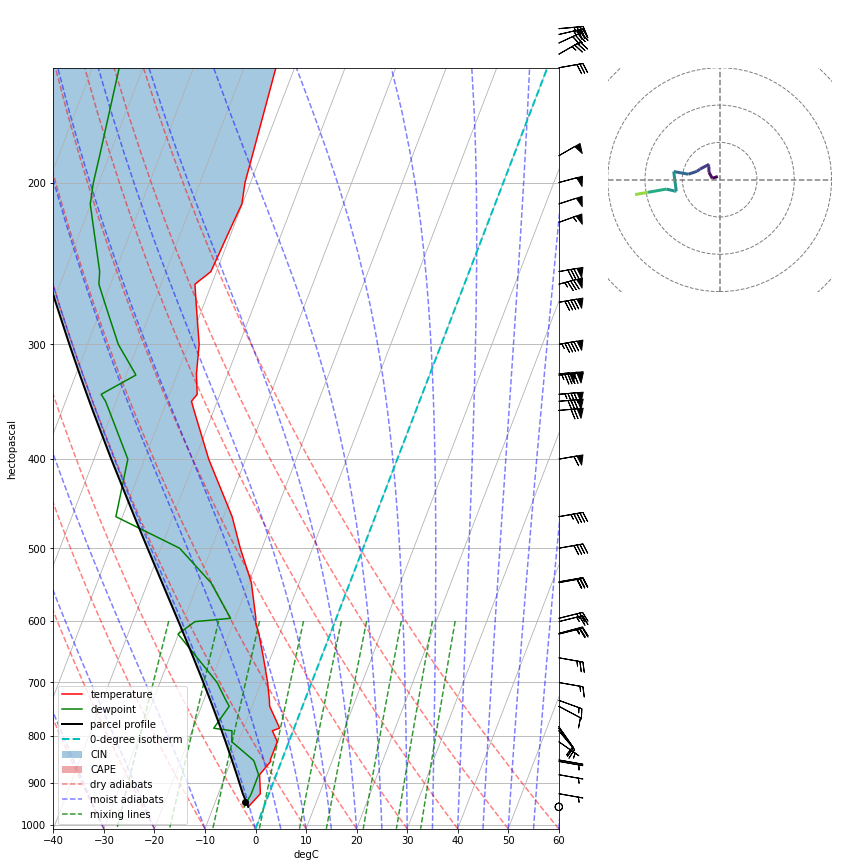

In [14]:
# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(14, 14))
gs = gridspec.GridSpec(3, 3)
skew = SkewT(fig, rotation=30, subplot=gs[:, :2])

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, t, 'r', label='temperature')
skew.plot(p, dt, 'g', label='dewpoint')
skew.plot_barbs(p, u, v)
skew.ax.set_ylim(round(p[0] + 50 * units.hPa, -1), 150) # y-axis start: add 50 to highest pressure and round to the nearest tenth
skew.ax.set_xlim(-40, 60)

# Plot LCL temperature as black dot
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')

# Plot the parcel profile as a black line
skew.plot(p, parcel_prof, 'k', linewidth=2, label='parcel profile')

# Shade areas of CAPE and CIN
skew.shade_cin(p, t, parcel_prof, label='CIN')
skew.shade_cape(p, t, parcel_prof, label='CAPE')

# Plot a zero degree isotherm
skew.ax.axvline(0, color='c', linestyle='--', linewidth=2, label='0-degree isotherm')

# Add the relevant special lines
skew.plot_dry_adiabats(label='dry adiabats')
skew.plot_moist_adiabats(label='moist adiabats')
skew.plot_mixing_lines(label='mixing lines')

# add a legend
plt.legend(loc='lower left')

# Create a hodograph (up to 400 hPa)
ax = fig.add_subplot(gs[0, -1])
h = Hodograph(ax, component_range=60.)
h.add_grid(increment=20)
h.plot_colormapped(u[:index400], v[:index400], wind_speed[:index400]) # Plot a line colored by wind speed and slicing the quantities with the help of the index
plt.axis('off')

# Show the plot
plt.show()

### Lapse-Rate

[Documentation of dry lapse rate](https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.dry_lapse.html#metpy.calc.dry_lapse)

In [ ]:
lr_d = mpcalc.dry_lapse(p,t[0])

In [ ]:
plt.plot(lr_d.to('degC'));